In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from src.special import saliency
from src.utils import  progress_log, visualization as viz
from src.core import models, training, data
from torchvision import transforms as T


DATA_DIR = '../snake_csv_files/'
DATA='../snake_total/SnakeCLEF2023-medium_size-train/'

MODEL_ARCH = 'deit_base_distilled_384'
MODEL_NAME = 'clef2023_deit_base_distilled_384_focal_05-05-2023_03-59-23'
OUTPUT_FILE = 'SnakeCLEF_bbox_annotations_full_train_val.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


In [2]:
train_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2023-cleaned-metadata-train-update.csv') # use common train csv file
valid_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2023-cleaned-metadata-val.csv')

classes = np.unique(train_df['binomial'])
no_classes = len(classes)
# assert no_classes == len(np.unique(valid_df['binomial_name']))
print(f'No classes: {no_classes}')
print(f'Train set length: {len(train_df):,d}')
print(f'Validation set length: {len(valid_df):,d}')

No classes: 1784
Train set length: 120,553
Validation set length: 10,985


In [3]:
# create model
model = models.get_model(MODEL_ARCH, no_classes, pretrained=True)
training.load_model(model, MODEL_NAME, path='.')
# assert np.all([param.requires_grad for param in model.parameters()])

model_config = model.pretrained_config

In [4]:


def get_transforms(*, size=224, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Create basic image transforms for training or validation dataset."""
    train_tfms = T.Compose([
        T.RandomResizedCrop((size, size), scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.RandomApply(torch.nn.ModuleList([
            T.ColorJitter(brightness=0.2, contrast=0.2)
        ]), p=0.2),  # random brightness contrast
        T.ToTensor(),
        T.Normalize(mean, std)])
    valid_tfms = T.Compose([
        T.Resize((size, size)),
        T.ToTensor(),
        T.Normalize(mean, std)])
    return train_tfms, valid_tfms

_, tfms = get_transforms(
    size=model_config['input_size'], mean=model_config['image_mean'],
    std=model_config['image_std'])

# create dataset
dataset = data.ImageDataset(
    pd.concat([train_df, valid_df], axis=0),
    img_path_col='image_path', label_col='binomial',
    path=DATA, bbox=False, transforms=tfms)

# dataset.show_items()

In [5]:
def find_bbox(model, img, label, device=None):
    # create saliency map
    saliency_map = saliency.get_saliency_map(model, img, label=label, device=device)

    # get bounding box covering highest intensities
    bbox, saliency_map_cleaned = saliency.get_bounding_box(
        saliency_map, bin_percentile=95, clust_pixel_th=10)
    _, h, w = img.shape
    # bbox = data.BBox(*bbox).normalize(h, w)  # normalize bbox
    return bbox

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

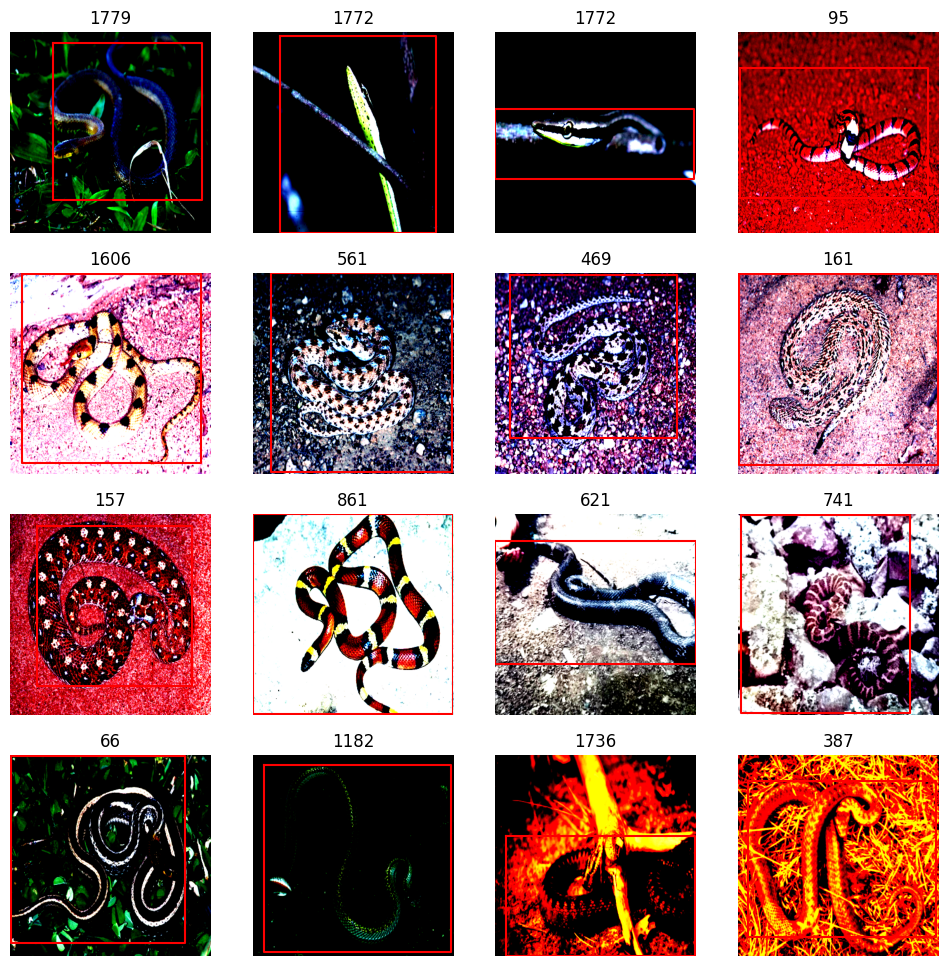

In [6]:
# visualize example
fig, axs = viz.create_fig(ncols=4, nrows=4, colsize=3, rowsize=3)
for i, ax in enumerate(axs):
    img, label = dataset[i]
    bbox = find_bbox(model, img, label, device=device)

    # bbox = bbox.denormalize(224, 224)
    viz.imshow(img, bbox=bbox, title=f'{label}', ax=ax)

In [7]:
from tqdm import tqdm

# create csv progress to save each step
csv_progress = progress_log.CSVProgress(
    filename=OUTPUT_FILE, path='.')

# iterate images and find bboxes
for i, (img, label) in tqdm(enumerate(dataset), total=len(dataset)):
    image_path = dataset.df['image_path'].iloc[i]
   
    bbox = find_bbox(model, img, label)
    xmin, ymin, xmax, ymax = bbox
    vals = {
        'image_path': image_path,
        'xmin': xmin,
        'ymin': ymin,
        'xmax': xmax,
        'ymax': ymax}
    csv_progress.log_epoch_scores(vals)

 33%|███▎      | 43054/131538 [13:05:09<22:15:50,  1.10it/s]   